In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
titanic_train = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

In [2]:
# We have a train dataset, which we'll use to train and validate our models, and the test dataset, which we'll submit the values
# Printing the columns and number of instances on the train and test datasets
print(titanic_train.columns)
print(titanic_test.columns)
print(titanic_train.shape)
print(titanic_test.shape)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(891, 12)
(418, 11)


In [3]:
# Counting the number of elements in each attribute
print(titanic_train.count())
# Checking the type of each attribute
print(titanic_train.dtypes)

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [4]:
# Using describe to analyse the numerial attributes
titanic_train.describe()
# There's missing values in Age and Cabin;
# 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked' are strings, we need to check if they're categorial or nominal;

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
print(titanic_train.Name.head())
# Name is identifier - discard
print(titanic_train.Sex.head())
# Sex is categorical, but binary - change to 0/1
print(titanic_train.Ticket.head())
# Ticket is a string, description - discard
print(titanic_train.Cabin.head())
# Cabin is a identifier, might be useful - discard, however
print(titanic_train.Embarked.head())
# Embarked is nominal - one-hot needed, discard for now

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object
0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object
0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object
0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object
0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object


In [6]:
# Create copy
ttn = titanic_train
# Drop all attributes we don't want
ttn = ttn.drop('PassengerId', axis=1)
ttn = ttn.drop('Name', axis=1)
ttn = ttn.drop('Ticket', axis=1)
ttn = ttn.drop('Cabin', axis=1)
ttn = ttn.drop('Embarked', axis=1)
# Change sex to a integer value
ttn['Sex'] = ttn['Sex'].replace({'male': 0, 'female': 1})
ttn_na = ttn.copy()
# Fill in age with the mean
ttn['Age'] = ttn['Age'].fillna(ttn['Age'].mean())

In [7]:
# Check correlation
for i in ttn.columns:
    print(ttn.corr()[i])

Survived    1.000000
Pclass     -0.338481
Sex         0.543351
Age        -0.069809
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64
Survived   -0.338481
Pclass      1.000000
Sex        -0.131900
Age        -0.331339
SibSp       0.083081
Parch       0.018443
Fare       -0.549500
Name: Pclass, dtype: float64
Survived    0.543351
Pclass     -0.131900
Sex         1.000000
Age        -0.084153
SibSp       0.114631
Parch       0.245489
Fare        0.182333
Name: Sex, dtype: float64
Survived   -0.069809
Pclass     -0.331339
Sex        -0.084153
Age         1.000000
SibSp      -0.232625
Parch      -0.179191
Fare        0.091566
Name: Age, dtype: float64
Survived   -0.035322
Pclass      0.083081
Sex         0.114631
Age        -0.232625
SibSp       1.000000
Parch       0.414838
Fare        0.159651
Name: SibSp, dtype: float64
Survived    0.081629
Pclass      0.018443
Sex         0.245489
Age        -0.179191
SibSp       0.414838
Parch       1.000000

In [8]:
# Normalize the dataset
temp = ttn.copy()
for feature_name in ttn.columns:
    maxv = ttn[feature_name].max()
    minv = ttn[feature_name].min()
    temp[feature_name] = (ttn[feature_name] - minv) / (maxv - minv)
ttn_norm = temp

In [9]:
# Function to split train (80%) and test (20%)
def split(df):
    X_train, X_test = train_test_split(df, test_size = 0.2)
    Y_train = X_train['Survived']
    X_train = X_train.drop('Survived', axis=1)
    Y_test = X_test['Survived']
    X_test = X_test.drop('Survived', axis=1)
    return X_train, Y_train, X_test, Y_test

# Split features and class for the cross validation
def crossval_split(df):
    Y = df['Survived']
    X = df.drop('Survived', axis=1)
    return X, Y

#K-NN function
def knn_run(db, n=5, weights='uniform', algorithm='auto', p=2):    
    X, Y = crossval_split(db)
    clf = KNeighborsClassifier(n_neighbors=n, weights=weights, algorithm=algorithm, p=p)
    scores = cross_val_score(clf, X, Y, cv=10)
    return scores

# Gaussian Naive Bayes
def bayes_run(db):
    X, Y = crossval_split(db)
    clf = GaussianNB()
    scores = cross_val_score(clf, X, Y, cv=10)
    return scores

# Decision Tree
def dectree_run(db, depth=None):
    X, Y = crossval_split(db)
    clf = tree.DecisionTreeClassifier(max_depth=depth)    
    scores = cross_val_score(clf, X, Y, cv=10)
    return scores

# SVM
from sklearn import svm
def svm_run(db, kernel='rbf', gamma='scale'):
    X, Y = crossval_split(db)
    clf = svm.SVC(gamma=gamma, kernel=kernel)
    scores = cross_val_score(clf, X, Y, cv=10)
    return scores

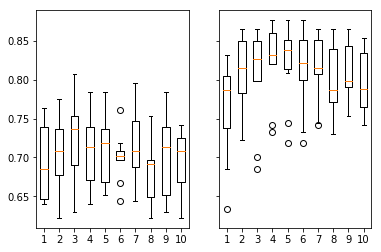

In [10]:
knn_score_list_orig = []
knn_score_list = []
for i in range(1,11):
    knn_score_list_orig.append(knn_run(ttn, n=i))
for i in range(1,11):
    knn_score_list.append(knn_run(ttn_norm, n=i))
    
# Compare normal database with a normalized one
fig1, ax1 = plt.subplots(ncols=2, sharey='all')
ax1[0].boxplot(knn_score_list_orig)
ax1[1].boxplot(knn_score_list)
plt.show()

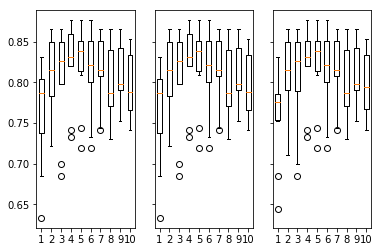

In [11]:
# Compare knn/algorithms
knn_score_list_ball = []
knn_score_list_kd = []
knn_score_list_brute = []
for i in range(1,11):
    knn_score_list_ball.append(knn_run(ttn_norm, n=i, algorithm='ball_tree'))
for i in range(1,11):
    knn_score_list_kd.append(knn_run(ttn_norm, n=i, algorithm='kd_tree'))
for i in range(1,11):
    knn_score_list_brute.append(knn_run(ttn_norm, n=i, algorithm='brute'))

fig1, ax1 = plt.subplots(ncols=3, sharey='all')
ax1[0].boxplot(knn_score_list_ball)
ax1[1].boxplot(knn_score_list_kd)
ax1[2].boxplot(knn_score_list_brute)
plt.show()

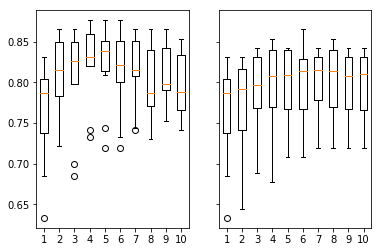

In [12]:
# Compare knn/weights
knn_score_list_uniform = []
knn_score_list_distance = []
for i in range(1,11):
    knn_score_list_uniform.append(knn_run(ttn_norm, n=i, weights='uniform'))
for i in range(1,11):
    knn_score_list_distance.append(knn_run(ttn_norm, n=i, weights='distance'))

fig1, ax1 = plt.subplots(ncols=2, sharey='all')
ax1[0].boxplot(knn_score_list_uniform)
ax1[1].boxplot(knn_score_list_distance)
plt.show()

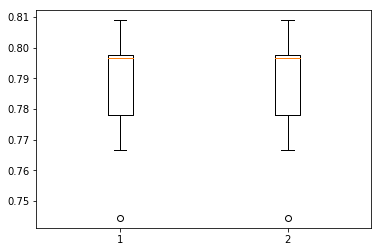

In [13]:
# Naive Bayes
fig1, ax1 = plt.subplots()
ax1.boxplot([bayes_run(ttn), bayes_run(ttn_norm)])
plt.show()

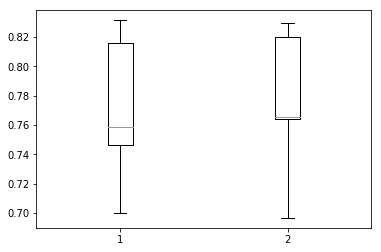

In [14]:
# Run Decision Tree to both datasets
dectree_score_orig = dectree_run(ttn) 
dectree_score = dectree_run(ttn_norm)
fig1, ax1 = plt.subplots()
ax1.boxplot([dectree_score_orig, dectree_score])
plt.show()

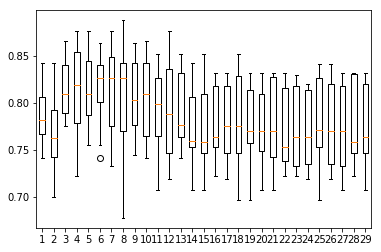

In [15]:
# Test multiple depths
dectree_score_depth = []
for i in range(1,30):
    dectree_score_depth.append(dectree_run(ttn, depth=i))
fig1, ax1 = plt.subplots()
ax1.boxplot(dectree_score_depth)
plt.show()

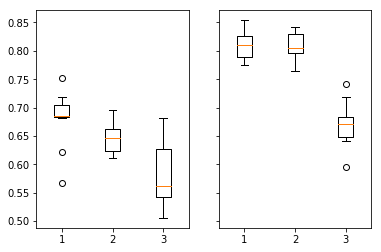

In [16]:
#
svm_score_orig = []
svm_score = []
for i in ['rbf', 'poly', 'sigmoid']:
    svm_score_orig.append(svm_run(ttn, kernel=i))
    svm_score.append(svm_run(ttn_norm, kernel=i))

fig1, ax1 = plt.subplots(ncols=2, sharey='all')
ax1[0].boxplot(svm_score_orig)
ax1[1].boxplot(svm_score)
plt.show()

In [17]:
# Gridsearch test
X_train, Y_train, X_test, Y_test = split(ttn_norm)
param = {'kernel':['rbf', 'linear', ]}
svc = svm.SVC(gamma='scale')
clf = GridSearchCV(svc, param, cv=5)
clf.fit(X_train, Y_train)
print(clf.best_params_)
print(clf.cv_results_['mean_test_score'])
print(clf.cv_results_['params'])

{'kernel': 'rbf'}
[0.79775281 0.78792135]
[{'kernel': 'rbf'}, {'kernel': 'linear'}]


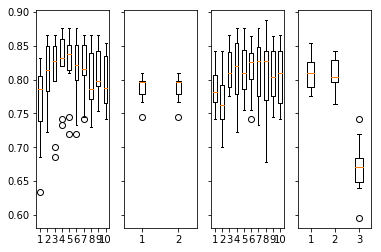

In [18]:
# Compare everybody
fig1, ax1 = plt.subplots(ncols=4, sharey='all')
ax1[0].boxplot(knn_score_list_uniform)
ax1[1].boxplot([bayes_run(ttn), bayes_run(ttn_norm)])
ax1[2].boxplot(dectree_score_depth[0:10])
ax1[3].boxplot(svm_score)
plt.show()

In [19]:
# Create copy
test = titanic_test
# Drop all attributes we don't want
test = test.drop('PassengerId', axis=1)
test = test.drop('Name', axis=1)
test = test.drop('Ticket', axis=1)
test = test.drop('Cabin', axis=1)
test = test.drop('Embarked', axis=1)
# Change sex to a integer value
test['Sex'] = test['Sex'].replace({'male': 0, 'female': 1})
# Fill in age with the mean
test = test.fillna(test.median())

# Normalize the dataset
temp = test.copy()
for feature_name in test.columns:
    maxv = test[feature_name].max()
    minv = test[feature_name].min()
    temp[feature_name] = (test[feature_name] - minv) / (maxv - minv)
test = temp

X, Y = crossval_split(ttn_norm)
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(X, Y)
prediction = clf.predict(test)

In [20]:
# Export results
data = {'PassengerId': titanic_test['PassengerId'], 'Survived': prediction.astype(int)}
pd.DataFrame(data).to_csv('submission.csv', index=False)